# Modeling


## import packages

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['font.family'].insert(0, 'Malgun Gothic')
%matplotlib inline
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

## load data/ preprocess

In [2]:
ex = pd.read_csv('data_0010VDS30450.csv', encoding='euc-kr')

In [3]:
ex = ex[['이전VDS', '이후VDS', 'holiday', '교통량', '평균속도' ] ]

In [4]:
look_back_size = 4
output_size = 4
train_size = 0.7

In [5]:
def create_dataset(array, look_back=4, output_size=4):
    # input 데이터를 time-step(=4) 만큼 전진하면서 분할
    X = []
    for i in range(len(array)-look_back-(output_size-1)):
        X.append(array[i:(i+look_back)])
    return np.array(X)

In [6]:
# ex) 전체 데이터 1행부터4행까지 + y변수 5행~8행이 한 세트
# 데이터프레임을 np.array로 변환후 함수 적용
Y = ex.평균속도
Y = np.array(Y)

In [7]:
ex = np.array(ex)
X = create_dataset(ex)
Y = create_dataset(Y)

In [8]:
print(X.shape)
print(Y.shape)

(1337, 4, 5)
(1337, 4)


## train-test split 

In [9]:
X_train_, X_test_ = X[:round(len(X)*train_size),:], X[round(len(X)*train_size):,:]
y_train, y_test = Y[:round(len(Y)*train_size),:], Y[round(len(Y)*train_size):,:]

In [10]:
X_train = X_train_.reshape(X_train_.shape[0], X_train_.shape[1], -1)
X_test = X_test_.reshape(X_test_.shape[0], X_test_.shape[1], -1)

In [11]:
print(X_train.shape)
print(y_train.shape)

(936, 4, 5)
(936, 4)


In [12]:
print(X_test.shape)
print(y_test.shape)

(401, 4, 5)
(401, 4)


## LSTM Model

In [13]:
verbose, epochs, batch_size = 0, 200, 12
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]

In [14]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(20, activation='relu', input_shape=(n_timesteps, n_features)))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(n_outputs))

opt = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model.compile(loss='mse', optimizer=opt)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20)                2080      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 44        
Total params: 2,334
Trainable params: 2,334
Non-trainable params: 0
_________________________________________________________________


In [15]:
hist = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

Instructions for updating:
Use tf.cast instead.


## evaluation 

In [16]:
y_pred = model.predict(X_test)
y_pred

array([[104.321785, 107.41073 , 123.99673 , 105.0035  ],
       [108.07422 , 122.41616 , 106.83514 , 137.07787 ],
       [120.47873 , 107.1518  , 137.38118 , 128.27861 ],
       ...,
       [ 85.113976,  87.45218 ,  88.921844,  87.586205],
       [ 86.816315,  90.086296,  87.30156 ,  86.69169 ],
       [ 89.87759 ,  88.18662 ,  86.03803 ,  85.56993 ]], dtype=float32)

In [17]:
y_test

array([[105.35, 108.06, 122.16, 105.66],
       [108.06, 122.16, 105.66, 138.07],
       [122.16, 105.66, 138.07, 128.32],
       ...,
       [ 84.97,  86.82,  89.04,  87.54],
       [ 86.82,  89.04,  87.54,  86.72],
       [ 89.04,  87.54,  86.72,  85.29]])

In [18]:
from sklearn.metrics import mean_squared_error

print('first step: ', mean_squared_error(y_test[:,0], y_pred[:,0]))
print('second step: ', mean_squared_error(y_test[:,1], y_pred[:,1]))
print('third step: ', mean_squared_error(y_test[:,2], y_pred[:,2]))
print('fourth step:', mean_squared_error(y_test[:,3], y_pred[:,3]))

first step:  3.5388304337900887
second step:  7.782994208051501
third step:  3.537473946702592
fourth step: 0.4788382280451903


## visualization

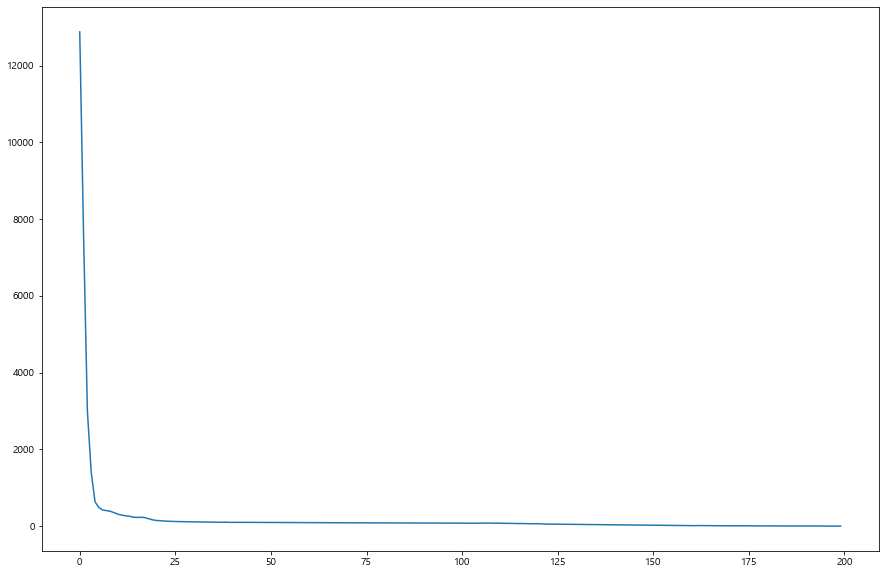

In [19]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(range(200), hist.history['loss'])

In [20]:
y_pred_00 = [i[0] for i in y_pred]
y_pred_15 = [i[1] for i in y_pred]
y_pred_30 = [i[2] for i in y_pred]
y_pred_45 = [i[-1] for i in y_pred]

y_test_00 = [i[0] for i in y_test]
y_test_15 = [i[1] for i in y_test]
y_test_30 = [i[2] for i in y_test]
y_test_45 = [i[3] for i in y_test]

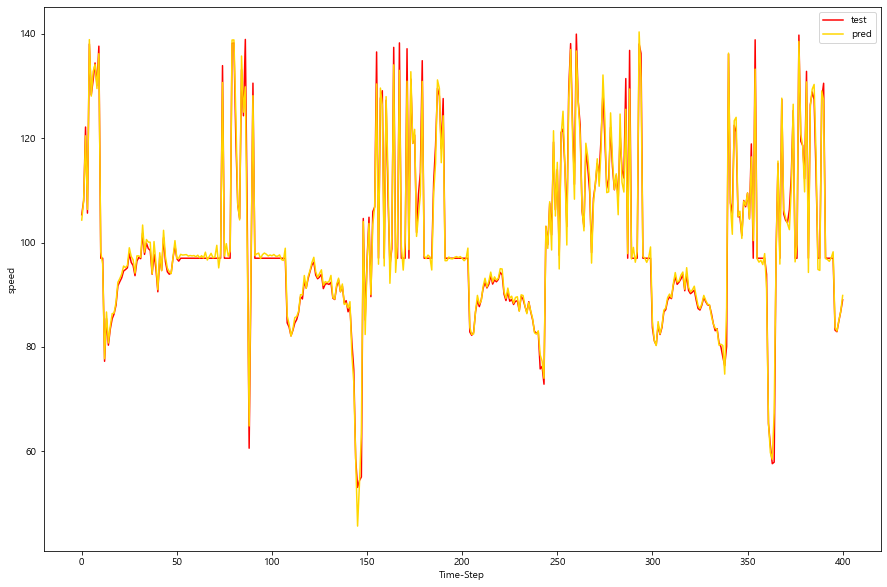

In [21]:
#plt.rcParams["figure.figsize"] = (20,10)
plt.figure(1)
plt.plot(range(401),y_test_00, color= 'r', label='test')
plt.plot(range(401),y_pred_00, color='gold',label='pred')
plt.xlabel('Time-Step')
plt.ylabel('speed')
plt.legend()